### Imports and definitions

In [1]:
import os
os.environ['PROJ_LIB'] = r"C:\Users\seonghohan\anaconda3\share\proj"
from mpl_toolkits.basemap import Basemap

import matplotlib
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
filenameHEPD = 'HEPD_DIV_20200717_0850_ORB_08795.h5'
filenameMEPD = 'MEPD_SCI_20200717_0851_ORB_08795.h5'

matplotlib.rcParams['figure.dpi'] = 200

In [3]:
jet = plt.cm.get_cmap('jet', 256)
newcolors = jet(np.linspace(0, 1, 256))
white = np.array([256/256, 256/256, 256/256, 1])
newcolors[0, :] = white
new_cmap = matplotlib.colors.ListedColormap(newcolors)

### Calculation functions

Subunit ID (column 4 in block1_values in MEPD data) is 3 for MEPD-A data and 4 for MEPD-B data

In [4]:
# Slice data into MEPD-A and MEPD-B (works for PC1 and TIME)
def sliceAB(data, subunit):
    A = []
    B = []
    for i in range(len(data)):
        if subunit[i] == 3:
            A.append(data[i])
        else:
            B.append(data[i])

    return A, B

# sliceAB but for 2D array data
def sliceAB2(data, subunit):
    A = []
    B = []
    for i in range(len(data)):
        if subunit[i] == 3:
            A.append(data[i, :])
        else:
            B.append(data[i, :])

    return A, B

In [5]:
# Calculate average magnetic field.
def B_avg(B):
    avg = []
    for i in range(len(B)):
        avg.append(np.sqrt((B[i, 4])**2 + (B[i, 5])**2 + (B[i, 6])**2))

    return avg

### Data reading functions

In [6]:
# Read TIME data
def read_TIME(filename):
    filepath = 'data/' + filename

    # group: MEPD_SCI or HEPD_DIV
    group = filename[0:8]
    dataset = 'block1_values'

    with h5py.File(filepath, 'r') as hdf:
        path = '/'+ group + '/' + dataset
        dataset = np.array(hdf[path])
    
    if group == 'HEPD_DIV':
        data = dataset[:, 7]
    if group == 'MEPD_SCI':
        data = dataset[:, 10]

    return data

In [7]:
# Read DT (Subunit ID) data
def read_DT(filename):
    filepath = 'data/' + filename

    # group: MEPD_SCI or HEPD_DIV
    group = filename[0:8]
    dataset = 'block1_values'

    with h5py.File(filepath, 'r') as hdf:
        path = '/'+ group + '/' + dataset
        dataset = np.array(hdf[path])
    
    data = dataset[:, 4]

    return data

In [8]:
# Read PC1 data
def read_PC1(filename):
    filepath = 'data/' + filename

    # group: MEPD_SCI or HEPD_DIV
    group = filename[0:8]
    dataset = 'block1_values'

    with h5py.File(filepath, 'r') as hdf:
        path = '/'+ group + '/' + dataset
        dataset = np.array(hdf[path])
    
    data = dataset[:, 5]

    return data

In [9]:
# Read satellite position data
def read_POS(filename):
    filepath = 'data/' + filename

    # group: MEPD_SCI or HEPD_DIV
    group = filename[0:8]
    dataset = 'block2_values'

    with h5py.File(filepath, 'r') as hdf:
        path = '/'+ group + '/' + dataset
        dataset = np.array(hdf[path])
    
    data = dataset[:, 16:18]

    return data

In [10]:
# Read magnetic field data
def read_MAG(filename):
    filepath = 'data/' + filename

    # group: HEPD_DIV or MEPD_SCI
    group = filename[0:8]
    dataset = 'block2_values'

    with h5py.File(filepath, 'r') as hdf:
        path = '/'+ group + '/' + dataset
        dataset = np.array(hdf[path])
    
    data = dataset[:, 0:8]

    return data

In [11]:
# Read detector data
def read_DET(filename):
    filepath = 'data/' + filename

    # group: HEPD_DIV or MEPD_SCI
    group = filename[0:8]
    dataset = 'block1_values'

    with h5py.File(filepath, 'r') as hdf:
        path = '/'+ group + '/' + dataset
        dataset = np.array(hdf[path])
    
    data0 = dataset[:, 13:77]
    data1 = dataset[:, 81:145]
    data2 = dataset[:, 149:213]
    data3 = dataset[:, 217:281]

    return data0, data1, data2, data3

### Plot data

In [12]:
# UNFINISHED: time
# Plot TIME vs. PC1
def plot_PC1(filename):
    # Read TIME data
    TIME = read_TIME(filename)
    # Read PC1 data
    PC1 = read_PC1(filename)
    # Read DT (Subunit ID) data
    DT = read_DT(filename)
    
    # Divide PC1 data into MEPD-A and MEPD-B
    PC1A, PC1B = sliceAB(PC1, DT)
    TIMEA, TIMEB = sliceAB(TIME, DT)
    
    # group: HEPD or MEPD
    group = filename[0:4]
    ax = plt.axes()
    if group == 'HEPD':
        ax.plot(PC1, TIME, '-xk')
    if group == 'MEPD':
        ax.plot(PC1A, TIMEA, '-xk', label='MEPD-A')
        ax.plot(PC1B, TIMEB, '-dr', label='MEPD-B')
        plt.legend()
        
    ax.tick_params(which='both', direction='in')
    ax.autoscale(enable=True, axis='both', tight=True)
    plt.title(group + ': Time vs PC1')
    plt.xlabel('PC1')
    plt.ylabel('Time (sec)')
    plt.show()

In [13]:
# Plot satellite position onto map
def plot_POS(filename):
    # Read TIME data
    TIME = read_TIME(filename)
    
    # Read POS data
    POS = read_POS(filename)
    LAT = POS[:, 0]
    LON = POS[:, 1]
    
    m = Basemap(projection='ortho', lat_0=-90, lon_0=0)
    m.drawcoastlines()
    m.drawmeridians(np.arange(0,360,45))
    m.drawparallels(np.arange(-90,90,30))
    
    X, Y = m(LON, LAT)
    m.plot(X[:-1], Y[:-1], '+r')
    m.plot(X[-1], Y[-1], 'ob')
    
    # Plot terminator
    mid_time = TIME[int(len(TIME)/2)]
    mid_time_utc = datetime.fromtimestamp(mid_time)
    m.nightshade(mid_time_utc)
    
    plt.title('Orbit (Orthographic projection)')
    plt.show()

In [14]:
# UNFINISHED: time
# Plot Magnetic Field vs. TIME.
def plot_MAG(filename):
    # Read TIME data
    TIME = read_TIME(filename)

    # Read magnetic field data
    MAG = read_MAG(filename)
    MAG_avg = B_avg(MAG)

    fig, ax = plt.subplots()
    ax.plot(TIME, MAG[:, 0], 'k', label='Bx')
    ax.plot(TIME, MAG[:, 1], 'b', label='By')
    ax.plot(TIME, MAG[:, 2], 'r', label='Bz')
    ax.plot(TIME, MAG[:, 4], '--k', label='IGRF Bx')
    ax.plot(TIME, MAG[:, 5], '--b', label='IGRF By')
    ax.plot(TIME, MAG[:, 6], '--r', label='IGRF Bz')
    ax.plot(TIME, MAG_avg, '--y', label='IGRF|B|')
    
    ax.tick_params(which='both', direction='in')
    plt.xlabel('Time')
    plt.ylabel('Magnetic Field (nT)')
    plt.ylim(-60000, 60000)
    plt.legend(loc='upper center', ncol=7)
    plt.show()

In [123]:
# UNFINISHED: time, different plot width
# Plot Detector Data (Energy) vs. TIME
def plot_DET(filename):
    # Read TIME data
    TIME = read_TIME(filename)

    # Read detector data
    DET0, DET1, DET2, DET3 = read_DET(filename)
    
    # Read DT (Subunit ID) data
    DT = read_DT(filename)
    
    # Divide PC1 data into MEPD-A and MEPD-B
    DET0A, DET0B = sliceAB2(DET0, DT)
    DET1A, DET1B = sliceAB2(DET1, DT)
    DET2A, DET2B = sliceAB2(DET2, DT)
    DET3A, DET3B = sliceAB2(DET3, DT)
    TIMEA, TIMEB = sliceAB(TIME, DT)
    y = np.linspace(0.0, 400.0, num=64)
    
    # Plot MEPD-A
    figA, (axA0, axA1, axA2, axA3) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 6))
    imA = axA0.imshow(X=np.transpose(DET0A), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    imA = axA1.imshow(X=np.transpose(DET1A), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    imA = axA2.imshow(X=np.transpose(DET2A), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    imA = axA3.imshow(X=np.transpose(DET3A), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    axA0.text(0.02, 0.85, 'Detector 0', horizontalalignment='left', transform=axA0.transAxes)
    axA1.text(0.02, 0.85, 'Detector 1', horizontalalignment='left', transform=axA1.transAxes)
    axA2.text(0.02, 0.85, 'Detector 2', horizontalalignment='left', transform=axA2.transAxes)
    axA3.text(0.02, 0.85, 'Detector 3', horizontalalignment='left', transform=axA3.transAxes)
    figA.subplots_adjust(left=0.0, right=0.9, bottom=0.05, top=0.95, wspace=0.0, hspace=0.0)
    cb_axA = figA.add_axes([0.92, 0.05, 0.02, 0.9])
    cbarA = figA.colorbar(imA, cax=cb_axA)
    axA1.set_ylabel('Energy [keV]') # Divde y label into two parts for center alignment
    axA2.set_ylabel('MEPD-A')
    
    # Plot MEPD-B
    figB, (axB0, axB1, axB2, axB3) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 6))
    imB = axB0.imshow(X=np.transpose(DET0B), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    imB = axB1.imshow(X=np.transpose(DET1B), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    imB = axB2.imshow(X=np.transpose(DET2B), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    imB = axB3.imshow(X=np.transpose(DET3B), origin='lower', cmap=new_cmap, aspect='auto', interpolation='none')
    axB0.text(0.02, 0.85, 'Detector 0', horizontalalignment='left', transform=axB0.transAxes)
    axB1.text(0.02, 0.85, 'Detector 1', horizontalalignment='left', transform=axB1.transAxes)
    axB2.text(0.02, 0.85, 'Detector 2', horizontalalignment='left', transform=axB2.transAxes)
    axB3.text(0.02, 0.85, 'Detector 3', horizontalalignment='left', transform=axB3.transAxes)
    figB.subplots_adjust(left=0.0, right=0.9, bottom=0.05, top=0.95, wspace=0.0, hspace=0)
    cb_axB = figB.add_axes([0.92, 0.05, 0.02, 0.9])
    cbarB = figB.colorbar(imB, cax=cb_axB)
    axB1.set_ylabel('Energy [keV]')
    axB2.set_ylabel('MEPD-B')

### Execution

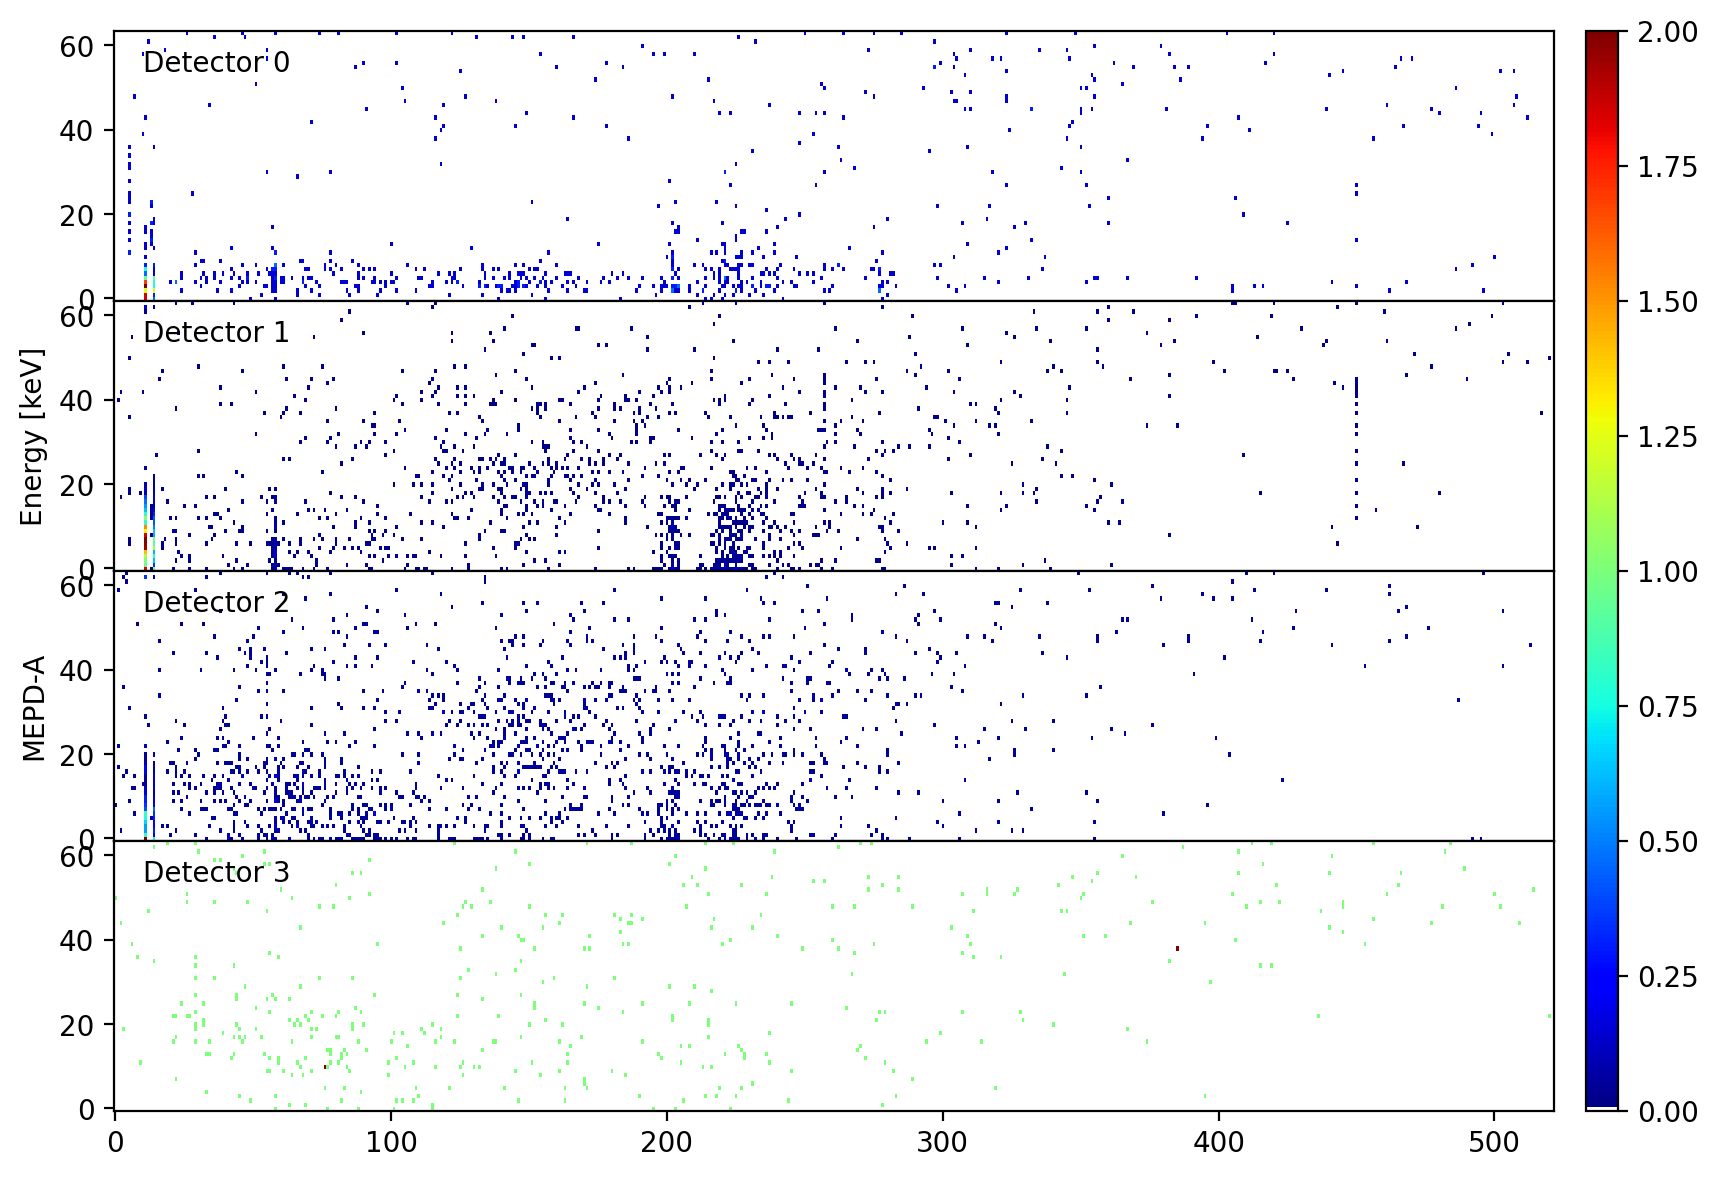

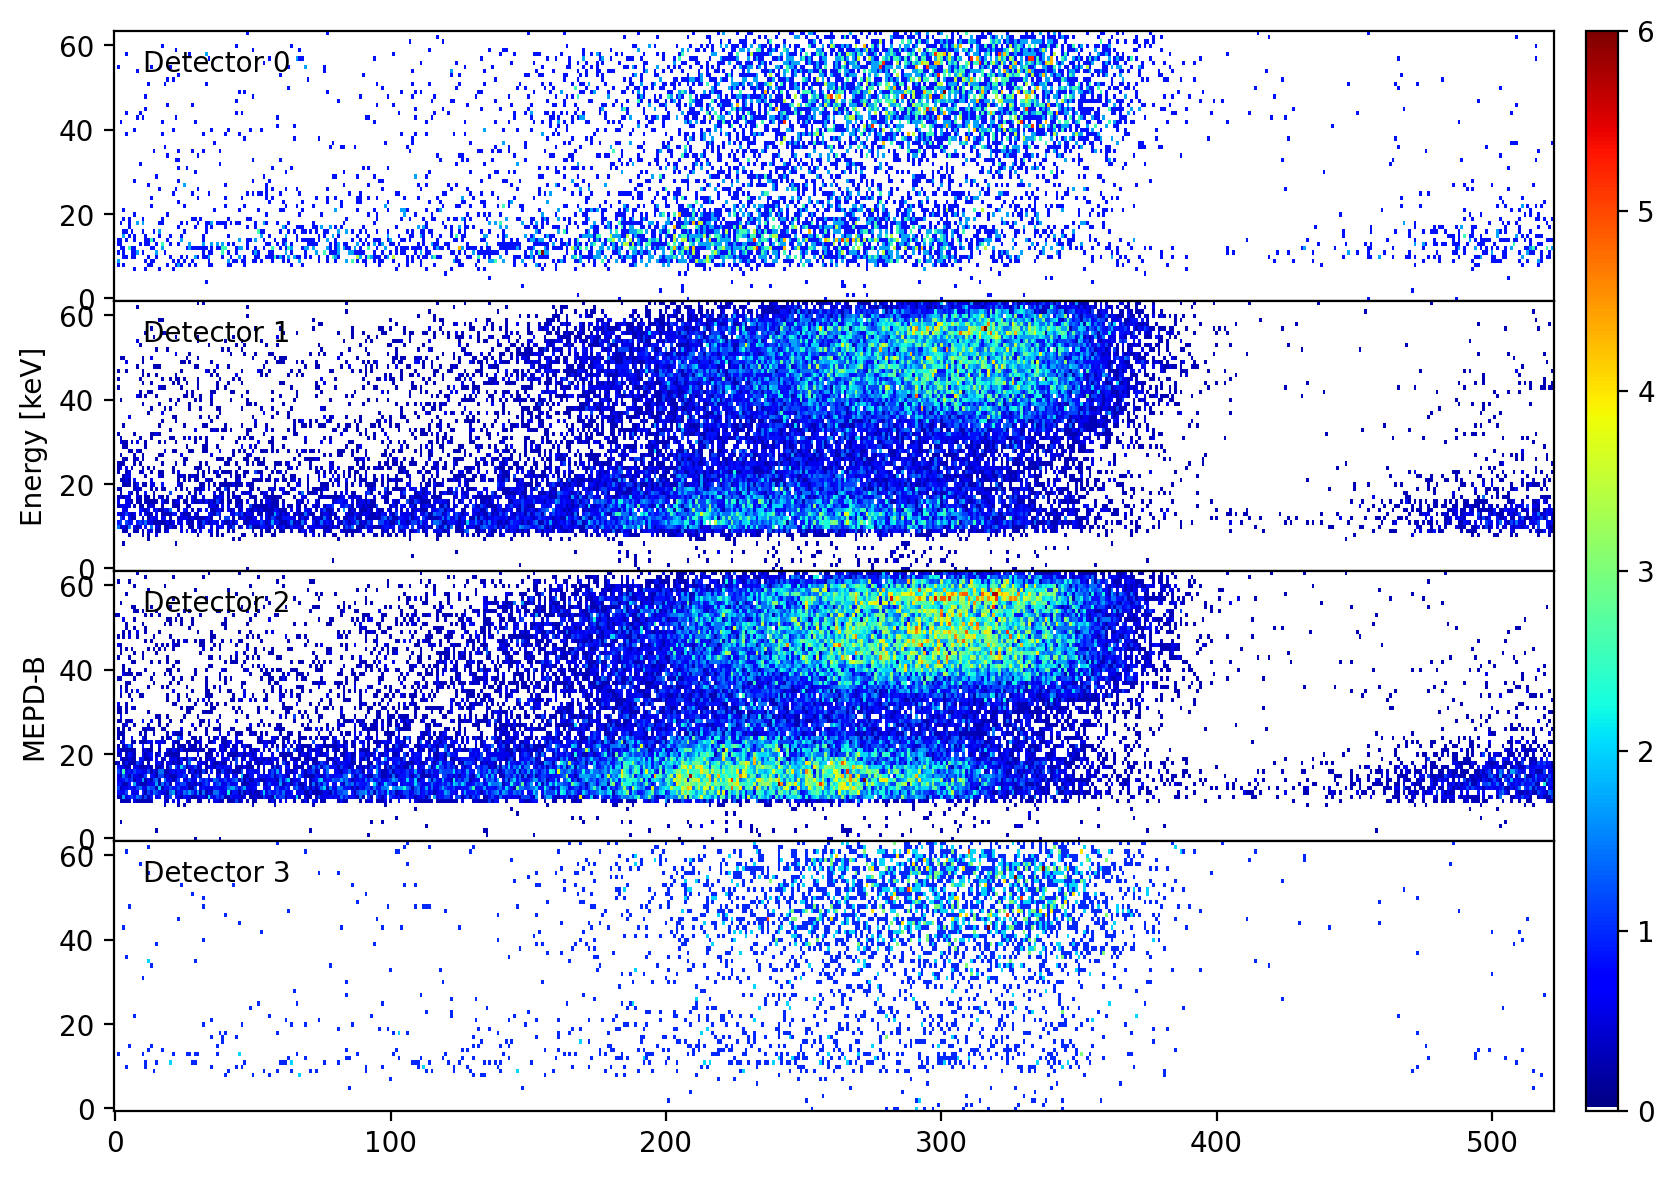

In [124]:
# PC1 plots require both HEPD and MEPD data.
#plot_PC1(filenameHEPD)
#plot_PC1(filenameMEPD)

# Satellite position plot can be obtained from either HEPD or MEPD data (might vary slightly).
#plot_POS(filenameHEPD)

# Magnetic field plot can be obtained from either HEPD or MEPD data (HEPD seems to be closer).
#plot_MAG(filenameHEPD)

# Detector plot uses MEPD data.
plot_DET(filenameMEPD)